### Anomaly Detection in Server Logs
#### CS 5614: Big Data Engineering
#### By: Vanessa Eichensehr and Bradley Freedman


**Project Objective:**  

Build a machine learning-based model that detects anomalies on a high volume high velocity log base. 

In [1]:
# Start Spark session

from pyspark.sql import SparkSession

spark = SparkSession.\
        builder.\
        appName("pyspark-kafka-streaming").\
        master("spark://spark-master:7077").\
        config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0"). \
        config("spark.executor.memory", "512m").\
        getOrCreate()

Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
:: loading settings :: url = jar:file:/usr/local/lib/python3.9/dist-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-813caf89-b6d0-4189-8e2e-19fa0bb84f8d;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.0.0 in central
	found org.apache.kafka#kafka-clients;2.4.1 in central
	found com.github.luben#zstd-jni;1.4.4-3 in central
	found org.lz4#lz4-java;1.7.1 in central
	found org.xerial.snappy#snappy-java;1.1.7.5 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.commons#commons-pool2;2.6.2 in central
:: resolution report :: resolve 570ms :: artifacts dl 27

**Step 1:** Load labeled training data

The training data was generated by our python script, log_generator.py. We injected anomalies into the script and labelled them as such. We aimed to have 5% anomalies in our training dataset, based on our research. 

In [2]:
training_df = spark.read.csv("/data/synthetic_with_anomalies_NEW.csv", header=True, inferSchema=True)
training_df.show(5)

+-------------+--------------------+------+--------------------+------+------+--------------------+--------------------+---------+-------------+
|           ip|                time|method|                path|status|  size|            referrer|          user_agent|anomalous|     category|
+-------------+--------------------+------+--------------------+------+------+--------------------+--------------------+---------+-------------+
| 54.36.149.86|2019-01-22 03:59:...|   GET|/image/8739/speci...|   200|179495|https://www.zanbi...|Mozilla/5.0 (X11;...|        0|not anomalous|
| 5.62.206.249|2019-01-22 03:59:...|   GET|      /settings/logo|   302|159434|https://www.zanbi...|Mozilla/5.0 (Wind...|        0|not anomalous|
| 54.36.149.16|2019-01-22 03:59:...|   GET|/product/4031/20/...|   302| 74066|https://www.zanbi...|Dalvik/2.1.0 (Lin...|        0|not anomalous|
|66.249.66.195|2019-01-22 03:59:...|   GET|/image/65274/prod...|   302| 66812|https://www-zanbi...|Mozilla/5.0 (Linu...|        0|

**Step 2:** Pre-process features 

In [3]:
!pip install numpy


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [6]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import unix_timestamp

# use UNIX time so it can be an integer
training_df = training_df.withColumn(
    "unix_time", 
    unix_timestamp("time", "yyyy-MM-dd HH:mm:ss.SSS")
)

# Define all categorical fields to index
categorical_cols = ["ip", "method", "path", "referrer", "user_agent"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_idx", handleInvalid="keep") for col in categorical_cols]

# Update VectorAssembler to include it
assembler = VectorAssembler(
    inputCols=["status", "size", "unix_time"] + [col + "_idx" for col in ["ip", "method", "path", "referrer", "user_agent"]],
    outputCol="features"
)

# note that REQUEST_TYPE = method
# note that REQUEST ARGUMENT = path 

label_indexer = StringIndexer(inputCol="anomalous", outputCol="label")  # for binary classification
# or: StringIndexer(inputCol="category", outputCol="label") for multi-class

print(training_df.columns)

# Combine steps
pipeline = Pipeline(stages=indexers + [assembler, label_indexer])
pipeline_model = pipeline.fit(training_df)
print("Pipeline fit completed")
pipeline_model.save("/data/pipeline_model_5")
print("Pipeline saved")

log_transformed = pipeline_model.transform(training_df)

# show whole dataframe
log_transformed.show(5)

# show features only 
log_transformed.select("features").show(truncate=False)

['ip', 'time', 'method', 'path', 'status', 'size', 'referrer', 'user_agent', 'anomalous', 'category', 'unix_time']
Pipeline fit completed


Pipeline saved
+-------------+--------------------+------+--------------------+------+------+--------------------+--------------------+---------+-------------+----------+------+----------+--------+------------+--------------+--------------------+-----+
|           ip|                time|method|                path|status|  size|            referrer|          user_agent|anomalous|     category| unix_time|ip_idx|method_idx|path_idx|referrer_idx|user_agent_idx|            features|label|
+-------------+--------------------+------+--------------------+------+------+--------------------+--------------------+---------+-------------+----------+------+----------+--------+------------+--------------+--------------------+-----+
| 54.36.149.86|2019-01-22 03:59:...|   GET|/image/8739/speci...|   200|179495|https://www.zanbi...|Mozilla/5.0 (X11;...|        0|not anomalous|1548129551|  79.0|       0.0|    59.0|        11.0|          25.0|[200.0,179495.0,1...|  0.0|
| 5.62.206.249|2019-01-22 03:59:.

**Step 3:** Split into train and test sets (use random seed to get consistent results)

In [7]:
train_data, test_data = log_transformed.randomSplit([0.8, 0.2], seed=42)

**Step 4:** Train Random Forest, Logistic Regression, Gradient Boosted Trees, and Multi-Layer Perceptron to do binary classification

In [8]:
# Random Forest
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    maxBins=1024  # default is 32, need to override it
)
rf_model = rf.fit(train_data)

In [9]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    regParam=0.01
)
lr_model = lr.fit(train_data)

25/05/06 03:42:50 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
25/05/06 03:42:50 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
25/05/06 03:42:51 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
25/05/06 03:42:51 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


In [10]:
# Gradient Boosted Trees
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(
    featuresCol="features",
    labelCol="label",
    maxIter=20, # Number of trees (iterations)
    maxDepth=5, # Max depth of each tree
    maxBins=1024 
)
# Train the model
gbt_model = gbt.fit(train_data)

In [12]:
# Multi-Layer Perceptron Classifier 
from pyspark.ml.classification import MultilayerPerceptronClassifier

num_features = train_data.select("features").first().features.size
num_classes = 2 # Binary classification
layers = [num_features, 10, num_classes]

mlpc = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="label",
    layers=layers,
    blockSize=128, # batch size
    seed=42,     # for reproduciblity
    maxIter=100
)

# Train the model
mlpc_model = mlpc.fit(train_data)

**Step 5:** Make predictions on test set

In [13]:
rf_predictions = rf_model.transform(test_data)
lr_predictions = lr_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)
mlpc_predictions = mlpc_model.transform(test_data)

**Step 6:** Evaluate models' performances

In [15]:
!pip install pandas
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 22.3 MB/s eta 0:00:0000:010:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 12.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 23.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


Random Forest Metrics:
AUC:       0.935
Accuracy:  0.974
Precision: 0.742
Recall:    0.720
F1 Score:  0.731

Logistic Regression Metrics:
AUC:       0.500
Accuracy:  0.951
Precision: 0.000
Recall:    0.000
F1 Score:  0.000

Gradient Boosted Tree Metrics:
AUC:       0.910
Accuracy:  0.971
Precision: 0.698
Recall:    0.740
F1 Score:  0.718

MLP Classifier Metrics:
AUC:       0.500
Accuracy:  0.951
Precision: 0.000
Recall:    0.000
F1 Score:  0.000



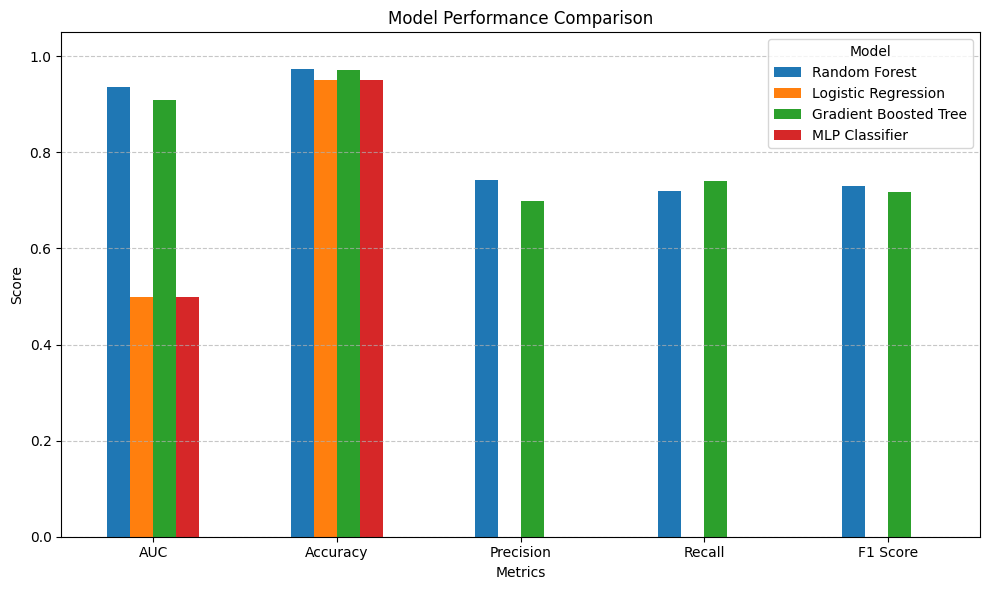

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, when

# Store results
model_results = []

def evaluate_models(predictions, model_name):
    auc_evaluator = BinaryClassificationEvaluator(
        labelCol="label",
        rawPredictionCol="rawPrediction",
        metricName="areaUnderROC"
    )
    auc = auc_evaluator.evaluate(predictions)

    predicted = predictions.select(
        col("label").cast("integer"),
        col("prediction").cast("integer")
    )

    tp = predicted.filter("label = 1 AND prediction = 1").count()
    tn = predicted.filter("label = 0 AND prediction = 0").count()
    fp = predicted.filter("label = 0 AND prediction = 1").count()
    fn = predicted.filter("label = 1 AND prediction = 0").count()

    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) else 0
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    print(f"{model_name} Metrics:")
    print(f"AUC:       {auc:.3f}")
    print(f"Accuracy:  {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 Score:  {f1:.3f}\n")

    model_results.append({
        "Model": model_name,
        "AUC": auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

evaluate_models(rf_predictions, "Random Forest")
evaluate_models(lr_predictions, "Logistic Regression")
evaluate_models(gbt_predictions, "Gradient Boosted Tree")
evaluate_models(mlpc_predictions, "MLP Classifier")

# Convert to DataFrame
results_df = pd.DataFrame(model_results)
results_df.set_index("Model", inplace=True)

# Transpose the DataFrame to flip metrics and models
results_df.T.plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.legend(title="Model", loc="upper right")
plt.tight_layout()
plt.show()

**Step 8:** Save models for future use

In [21]:
rf_model.save('/data/_rf_binary_classifier')
lr_model.save('/data/_lr_binary_classifier')
gbt_model.save('/data/_gbt_binary_classifier')
mlpc_model.save('/data/_mlpc_binary_classifier')

**Model Selection**: Random Forest and Gradient Boosted Trees performed significantly better than Logistic Regression and Multi-layer perceptron models. 
- Logistic Regression struggles with anomaly detection because it assumes a linear separation between classes, but anomalies usually have complex, non-linear patterns.
- Multilayer Perceptrons (MLPCs) can model non-linearity but can require tuning and scaling (hard to scale and tune when data is constantly training). 
- Tree-based models like Random Forest and GBT generally perform better because they naturally handle non-linear relationships and feature interactions without requiring extensive feature scaling 

We ultimately selected **Random Forest** because it performed the best. 

**Step 9:** 
Create a streaming DataFrame in Spark that reads data from a Kafka topic named "topic_test" and starts
processing from the beginning of the topic's log using the earliest available offset. Use kafka:9093 as the bootstrap
server.

In [22]:
df_streamed_raw = (spark.readStream.format("kafka").option("kafka.bootstrap.servers", "kafka:9093").option("subscribe", "topic_test").load())

In [23]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import col

# convert byte stream to string
df_streamed_kv = (df_streamed_raw
    .withColumn("key", df_streamed_raw["key"].cast(StringType()))
    .withColumn("value", df_streamed_raw["value"].cast(StringType())))

test_query = (df_streamed_kv 
              .writeStream \
              .format("memory") # output to memory \
              .outputMode("update") # only write updated rows to the sink \
              .queryName("test_query_table")  # Name of the in memory table \
              .start())

25/05/06 03:55:17 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-c36f1352-d995-4c9f-a1ee-654d2ee2e3a7. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


The following cell should display a table populated with values being streamed from you Kafka producer.

In [24]:
spark.sql("select * from test_query_table").show()

+----+--------------------+----------+---------+------+--------------------+-------------+
| key|               value|     topic|partition|offset|           timestamp|timestampType|
+----+--------------------+----------+---------+------+--------------------+-------------+
|9608|{"ip_address": "5...|topic_test|        0|168525|2025-05-06 03:55:...|            0|
|9609|{"ip_address": "5...|topic_test|        0|168526|2025-05-06 03:55:...|            0|
|9610|{"ip_address": "5...|topic_test|        0|168527|2025-05-06 03:55:...|            0|
|9611|{"ip_address": "5...|topic_test|        0|168528|2025-05-06 03:55:...|            0|
|9612|{"ip_address": "9...|topic_test|        0|168529|2025-05-06 03:55:...|            0|
|9613|{"ip_address": "5...|topic_test|        0|168530|2025-05-06 03:55:...|            0|
|9614|{"ip_address": "5...|topic_test|        0|168531|2025-05-06 03:55:...|            0|
|9615|{"ip_address": "5...|topic_test|        0|168532|2025-05-06 03:55:...|            0|

In [25]:
test_query.stop()

The following cells contain code that take the streamed dataframe and formats it properly into a table. If any of the given cells fails, there might be a formatting issue with one of your previous solutions. 

In [26]:
from pyspark.sql.functions import from_json
from pyspark.sql.types import StructType, StructField, BooleanType, LongType, IntegerType

event_schema = StructType([
    StructField("ip_address", StringType()),
    StructField("date_time", StringType()),
    StructField("request_type", StringType()),
    StructField("request_arg", StringType()),
    StructField("status_code", StringType()),
    StructField("response_size", StringType()),
    StructField("referrer", StringType()),
    StructField("user_agent", StringType())
])

# Parse the events from JSON format
df_parsed = (df_streamed_kv
           # Sets schema for event data
           .withColumn("value", from_json("value", event_schema))
          )

In [27]:
df_formatted = (df_parsed.select(
    col("key").alias("event_key")
    ,col("topic").alias("event_topic")
    ,col("timestamp").alias("event_timestamp")
    ,col("value.ip_address").alias("ip_address")
    ,col("value.date_time").alias("date_time")
    ,col("value.request_type").alias("request_type")
    ,col("value.request_arg").alias("request_arg")
    ,col("value.status_code").alias("status_code")
    ,col("value.response_size").cast(IntegerType()).alias("response_size")
    ,col("value.referrer").alias("referrer")
    ,col("value.user_agent").alias("user_agent")
))

In [28]:
# Write the parsed data to console
query = (df_formatted.writeStream.format("console").outputMode("append").trigger(processingTime='5 seconds').start())

25/05/06 03:55:51 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-48485917-112c-44df-9625-3952b9ce1f52. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


-------------------------------------------
Batch: 0
-------------------------------------------
+---------+-----------+---------------+----------+---------+------------+-----------+-----------+-------------+--------+----------+
|event_key|event_topic|event_timestamp|ip_address|date_time|request_type|request_arg|status_code|response_size|referrer|user_agent|
+---------+-----------+---------------+----------+---------+------------+-----------+-----------+-------------+--------+----------+
+---------+-----------+---------------+----------+---------+------------+-----------+-----------+-------------+--------+----------+

-------------------------------------------
Batch: 1
-------------------------------------------
+---------+-----------+--------------------+-------------+--------------------+------------+--------------------+-----------+-------------+--------------------+--------------------+
|event_key|event_topic|     event_timestamp|   ip_address|           date_time|request_type|   

In [29]:
# Print the name of active streams (This may be useful during debugging)
for s in spark.streams.active:
    print(f"ID:{s.id} | NAME:{s.name}")

ID:cd041605-9915-44c5-aacf-6c39b73d865a | NAME:None


In [30]:
query.stop()

**Step 10:** Batch/Rolling window incoming data, make predictions on it using random forest model

In [32]:
from pyspark.ml import PipelineModel
from pyspark.ml.classification import RandomForestClassificationModel
from pyspark.sql.functions import *
from pyspark.sql.functions import unix_timestamp

kafka_timestamp_format = "dd/MMM/yyyy:HH:mm:ss Z"

# Convert date_time from string to timestamp using the correct format
df_formatted = df_formatted.withColumn(
    "event_time",
    coalesce(
        to_timestamp(col("date_time"), kafka_timestamp_format),
    )
)

# Filter out rows where timestamp parsing failed (resulted in null)
df_formatted = df_formatted.filter(col("event_time").isNotNull())

# create windows
windowed_df = df_formatted.withWatermark("event_time", "10 seconds")

# adjust names to match the dataset used for training
renamed_df = windowed_df.selectExpr(
    "ip_address as ip",
    "request_type as method",
    "request_arg as path",
    "status_code as status",
    "response_size as size",
    "referrer",
    "user_agent",
    "event_time"
)

# convert data to ints and calculate unix_time
renamed_df = renamed_df \
    .withColumn("status", coalesce(col("status").cast("int"), lit(0))) \
    .withColumn("size", coalesce(col("size").cast("int"), lit(0))) \
    .withColumn("unix_time", unix_timestamp("event_time"))

# Filter again for safety before applying models, ensuring unix_time is not null
renamed_df = renamed_df.filter(col("unix_time").isNotNull())

# Load transformation pipeline and classifier
pipeline_model = PipelineModel.load("/data/pipeline_model_5")
rf_model = RandomForestClassificationModel.load("/data/_rf_binary_classifier")
transformed_df = pipeline_model.transform(renamed_df)

# make predictions
predictions = rf_model.transform(transformed_df)

# Get only anomalies
anomalies_df = predictions.filter(col("prediction") == 1.0)

# Print full rows if anomalies are detected
query = anomalies_df.writeStream \
    .outputMode("append") \
    .format("console") \
    .option("truncate", False) \
    .start()

25/05/06 03:56:50 WARN StringIndexerModel: Input column anomalous does not exist during transformation. Skip StringIndexerModel for this column.
25/05/06 03:56:50 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-4573bbe7-d505-4924-8b3c-35c89b3f73ff. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


-------------------------------------------
Batch: 0
-------------------------------------------
+---+------+----+------+----+--------+----------+----------+---------+------+----------+--------+------------+--------------+--------+-------------+-----------+----------+
|ip |method|path|status|size|referrer|user_agent|event_time|unix_time|ip_idx|method_idx|path_idx|referrer_idx|user_agent_idx|features|rawPrediction|probability|prediction|
+---+------+----+------+----+--------+----------+----------+---------+------+----------+--------+------------+--------------+--------+-------------+-----------+----------+
+---+------+----+------+----+--------+----------+----------+---------+------+----------+--------+------------+--------------+--------+-------------+-----------+----------+

-------------------------------------------
Batch: 1
-------------------------------------------
+-------------+------+-----------------------------------------------------------------------------------------------

In [33]:
query.stop()